
Simulation for Primary Power = 15 dB

Secondary User Positions and Received Powers:
User ID | Position (x, y) | Received Power (Primary) | Received Power (PUEA)
----------------------------------------------------------------------
      1 | ( 37.45,  95.07) |               -31.67 |             -37.13
      2 | ( 73.20,  59.87) |               -39.32 |             -28.57
      3 | ( 15.60,  15.60) |               -13.92 |             -35.86
      4 | (  5.81,  86.62) |               -49.10 |             -60.33
      5 | ( 60.11,  70.81) |               -26.55 |             -18.71
      6 | (  2.06,  96.99) |               -53.93 |             -64.03
      7 | ( 83.24,  21.23) |               -29.14 |             -38.40
      8 | ( 18.18,  18.34) |               -23.63 |             -53.22
      9 | ( 30.42,  52.48) |               -29.52 |             -48.33
     10 | ( 43.19,  29.12) |                -9.13 |             -32.58
     11 | ( 61.19,  13.95) |               -41.74 |      

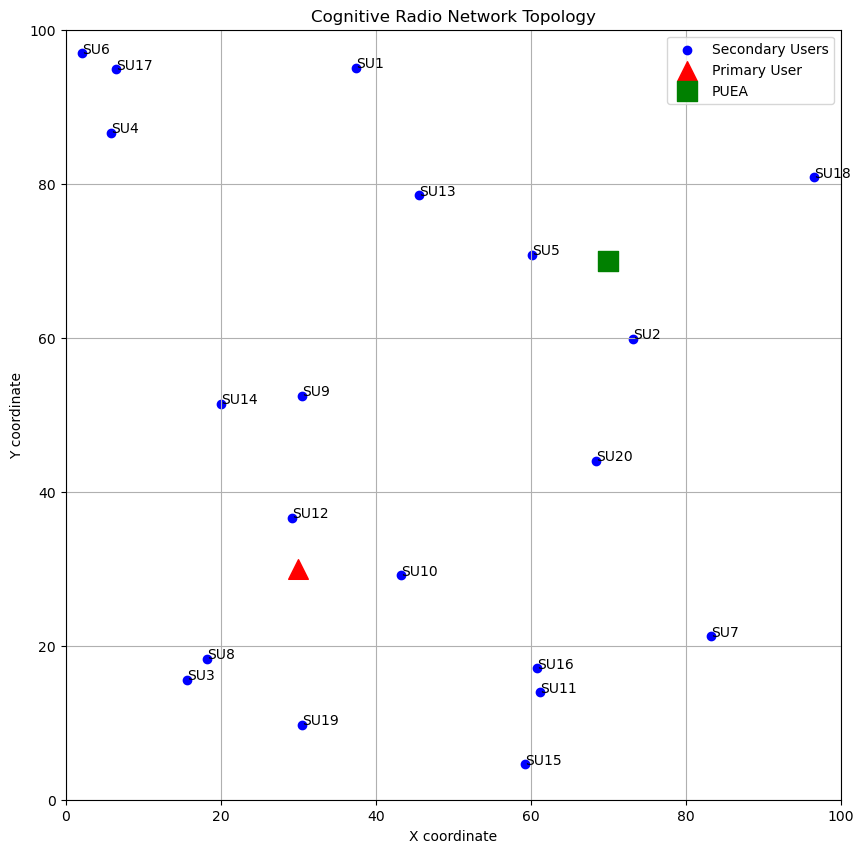


Iteration 1:
Array of received powers from Primary User: [-31.6714811  -39.3227164  -13.91990156 -49.10092717 -26.55319645
 -53.92606672 -29.14344688 -23.63419635 -29.52422154  -9.12603525
 -41.73530275 -10.56243911 -54.5822542  -38.30464437 -34.41615577
 -39.65121185 -26.94968675 -31.74071854 -16.73020182 -32.50603003]
Array of received powers from PUEA: [-37.12591525 -28.57291911 -35.86193771 -60.33049688 -18.71484291
 -64.02953788 -38.39553622 -53.21848393 -48.32560376 -32.58125358
 -59.96451937 -52.40182604 -53.13793025 -61.69543407 -51.87316883
 -57.60882272 -36.83769934 -30.61097223 -38.25841243 -37.30536755]

Iteration 2:
Array of received powers from Primary User: [-48.17855401 -22.55867164 -52.82567859 -36.20887434 -45.86186171
 -24.53800835 -39.00901862 -31.6928663  -18.13415696 -58.71539617
 -58.22673325 -35.53117232 -31.51060326 -32.0580263   -7.43171932
 -28.04779877 -37.72747548 -49.04685354 -41.58911512 -26.54171644]
Array of received powers from PUEA: [-66.60731265 -49

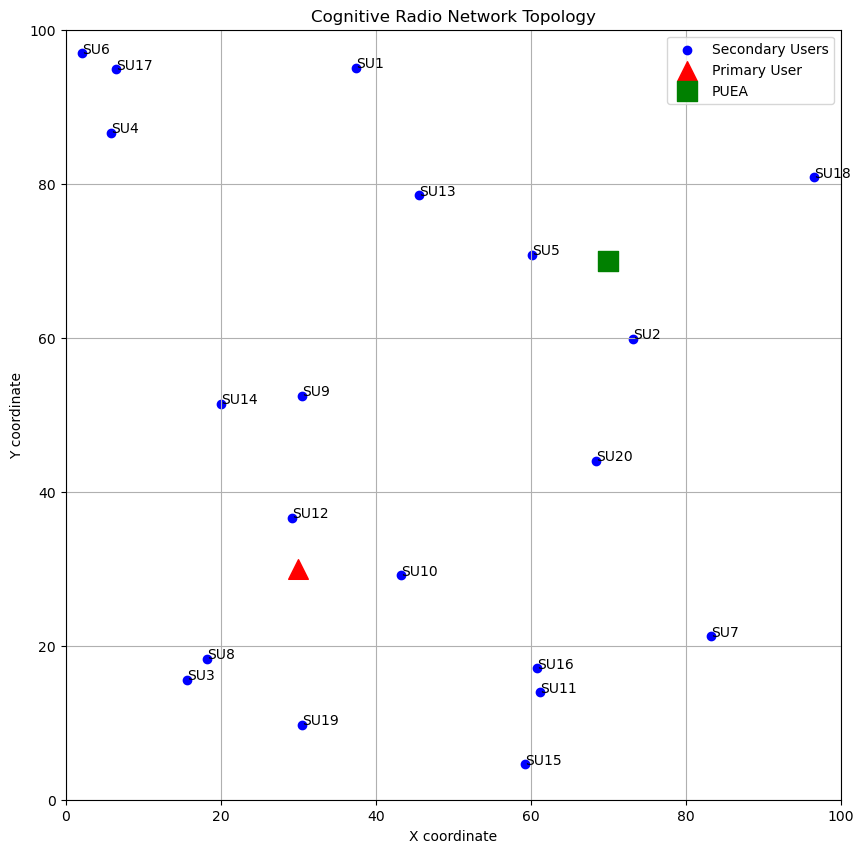


Iteration 1:
Array of received powers from Primary User: [-26.6714811  -34.3227164   -8.91990156 -44.10092717 -21.55319645
 -48.92606672 -24.14344688 -18.63419635 -24.52422154  -4.12603525
 -36.73530275  -5.56243911 -49.5822542  -33.30464437 -29.41615577
 -34.65121185 -21.94968675 -26.74071854 -11.73020182 -27.50603003]
Array of received powers from PUEA: [-37.12591525 -28.57291911 -35.86193771 -60.33049688 -18.71484291
 -64.02953788 -38.39553622 -53.21848393 -48.32560376 -32.58125358
 -59.96451937 -52.40182604 -53.13793025 -61.69543407 -51.87316883
 -57.60882272 -36.83769934 -30.61097223 -38.25841243 -37.30536755]

Iteration 2:
Array of received powers from Primary User: [-43.17855401 -17.55867164 -47.82567859 -31.20887434 -40.86186171
 -19.53800835 -34.00901862 -26.6928663  -13.13415696 -53.71539617
 -53.22673325 -30.53117232 -26.51060326 -27.0580263   -2.43171932
 -23.04779877 -32.72747548 -44.04685354 -36.58911512 -21.54171644]
Array of received powers from PUEA: [-66.60731265 -49

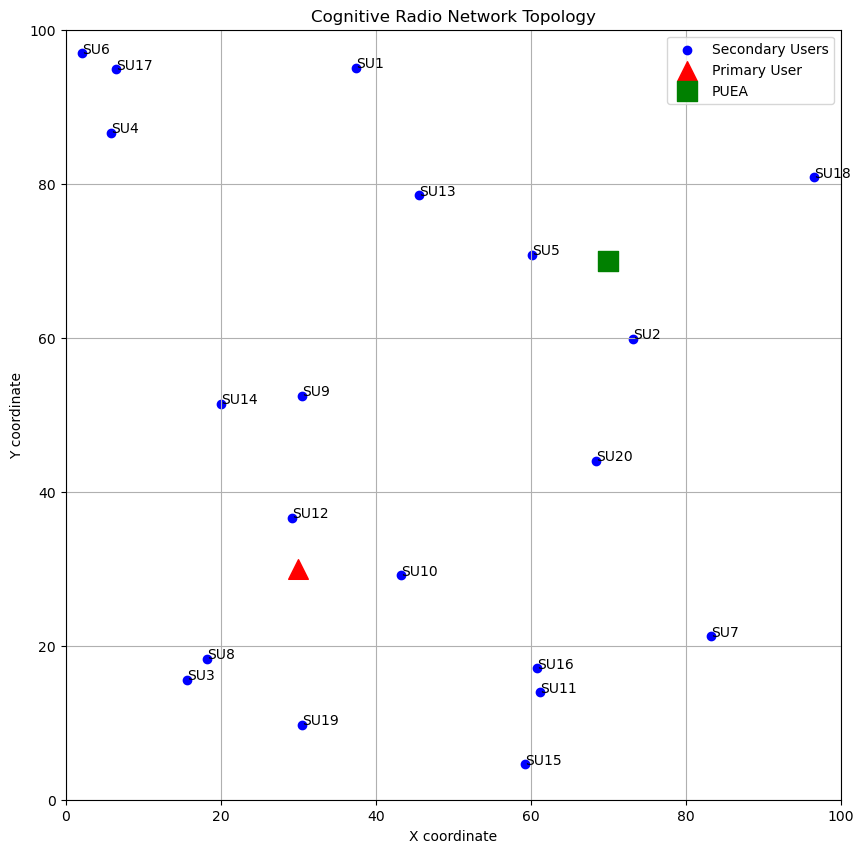


Iteration 1:
Array of received powers from Primary User: [-21.6714811  -29.3227164   -3.91990156 -39.10092717 -16.55319645
 -43.92606672 -19.14344688 -13.63419635 -19.52422154   0.87396475
 -31.73530275  -0.56243911 -44.5822542  -28.30464437 -24.41615577
 -29.65121185 -16.94968675 -21.74071854  -6.73020182 -22.50603003]
Array of received powers from PUEA: [-37.12591525 -28.57291911 -35.86193771 -60.33049688 -18.71484291
 -64.02953788 -38.39553622 -53.21848393 -48.32560376 -32.58125358
 -59.96451937 -52.40182604 -53.13793025 -61.69543407 -51.87316883
 -57.60882272 -36.83769934 -30.61097223 -38.25841243 -37.30536755]

Iteration 2:
Array of received powers from Primary User: [-38.17855401 -12.55867164 -42.82567859 -26.20887434 -35.86186171
 -14.53800835 -29.00901862 -21.6928663   -8.13415696 -48.71539617
 -48.22673325 -25.53117232 -21.51060326 -22.0580263    2.56828068
 -18.04779877 -27.72747548 -39.04685354 -31.58911512 -16.54171644]
Array of received powers from PUEA: [-66.60731265 -49

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2)**2))

def calculate_received_power(tx_power, distance, path_loss_exp, shadowing):
    path_loss = 10 * path_loss_exp * np.log10(distance)
    received_power = tx_power - path_loss + shadowing
    return received_power

def combine_arrays(arr1, arr2):
    if not isinstance(arr1, list) or not isinstance(arr2, list):
        # Convert numpy arrays to lists if needed
        arr1 = arr1.tolist() if isinstance(arr1, np.ndarray) else arr1
        arr2 = arr2.tolist() if isinstance(arr2, np.ndarray) else arr2

    first_array_count = int(len(arr1) * 0.75)
    second_array_count = int(len(arr2) * 0.25)

    first_part = arr1[:first_array_count]
    second_part = arr2[-second_array_count:]

    return first_part + second_part

def run_simulation(primary_power, num_iterations=3):
    # Network parameters
    num_secondary_users = 20
    area_size = 100
    puea_power = 5
    shadowing_std_dev = 4

    # Initialize result matrix
    result_matrix = []

    for iteration in range(num_iterations):
        # Set random seed for reproducibility but different for each iteration
        np.random.seed(42 + iteration)

        # Generate random positions
        secondary_positions = np.random.uniform(0, area_size, size=(num_secondary_users, 2))
        primary_position = np.array([30, 30])
        puea_position = np.array([70, 70])

        # Initialize arrays
        distances_to_primary = np.zeros(num_secondary_users)
        distances_to_puea = np.zeros(num_secondary_users)
        path_loss_exponents = np.random.uniform(2, 4, num_secondary_users)
        shadowing_values = np.random.normal(0, shadowing_std_dev, num_secondary_users)
        received_powers_primary = np.zeros(num_secondary_users)
        received_powers_puea = np.zeros(num_secondary_users)

        # Calculate features
        for i in range(num_secondary_users):
            distances_to_primary[i] = calculate_distance(secondary_positions[i], primary_position)
            distances_to_puea[i] = calculate_distance(secondary_positions[i], puea_position)

            received_powers_primary[i] = calculate_received_power(
                primary_power,
                distances_to_primary[i],
                path_loss_exponents[i],
                shadowing_values[i]
            )

            received_powers_puea[i] = calculate_received_power(
                puea_power,
                distances_to_puea[i],
                path_loss_exponents[i],
                shadowing_values[i]
            )

        # Print table for first iteration
        if iteration == 0:
            print("\nSecondary User Positions and Received Powers:")
            print("User ID | Position (x, y) | Received Power (Primary) | Received Power (PUEA)")
            print("-" * 70)
            for i in range(num_secondary_users):
                print(f"{i+1:7d} | ({secondary_positions[i,0]:6.2f}, {secondary_positions[i,1]:6.2f}) | "
                      f"{received_powers_primary[i]:20.2f} | {received_powers_puea[i]:18.2f}")

            # Plot network topology
            plt.figure(figsize=(10, 10))
            plt.scatter(secondary_positions[:, 0], secondary_positions[:, 1],
                       label='Secondary Users', c='blue', marker='o')
            plt.scatter(primary_position[0], primary_position[1],
                       label='Primary User', c='red', marker='^', s=200)
            plt.scatter(puea_position[0], puea_position[1],
                       label='PUEA', c='green', marker='s', s=200)

            for i in range(num_secondary_users):
                plt.annotate(f'SU{i+1}', (secondary_positions[i, 0], secondary_positions[i, 1]))

            plt.title('Cognitive Radio Network Topology')
            plt.xlabel('X coordinate')
            plt.ylabel('Y coordinate')
            plt.grid(True)
            plt.legend()
            plt.axis([0, area_size, 0, area_size])
            plt.show()

        # Print power arrays
        print(f"\nIteration {iteration + 1}:")
        print("Array of received powers from Primary User:", received_powers_primary)
        print("Array of received powers from PUEA:", received_powers_puea)

        # Combine arrays in 3:1 ratio
        combined_array = combine_arrays(received_powers_primary, received_powers_puea)

        # Append to result matrix
        result_matrix.append(combined_array)

    return np.array(result_matrix)

# Example usage
primary_powers = [15, 20, 25]  # Different values of primary power
final_matrices = []

for pr in primary_powers:
    print(f"\nSimulation for Primary Power = {pr} dB")
    result = run_simulation(pr, num_iterations=3)
    final_matrices.append(result)
    print("\nResult Matrix:")
    print(result)

# Final combined matrix for all primary powers
final_matrix = np.vstack(final_matrices)
print("\nFinal Combined Matrix for all Primary Powers:")
print(final_matrix)

In [5]:
import numpy as np

def calculate_statistics(data_array):

    mean = round(np.mean(data_array), 2)
    median = round(np.median(data_array), 2)
    variance = round(np.var(data_array), 2)
    upper_quartile = round(np.percentile(data_array, 75), 2)
    lower_quartile = round(np.percentile(data_array, 25), 2)
    return [mean, median, variance, upper_quartile, lower_quartile]

def process_array_of_arrays(array_of_array1):

    array_of_array2 = []
    for element in array_of_array1:
        statistics = calculate_statistics(element)
        array_of_array2.append(statistics)
    return array_of_array2

array_of_array2 = process_array_of_arrays(final_matrix)
print(array_of_array2)

[[-34.31, -35.63, 177.14, -28.5, -39.93], [-38.31, -39.24, 171.94, -31.65, -46.44], [-36.82, -35.42, 133.0, -28.78, -46.18], [-30.56, -31.96, 196.37, -23.5, -37.54], [-34.56, -36.74, 192.68, -26.65, -44.99], [-33.07, -31.54, 147.53, -23.78, -43.06], [-26.81, -28.81, 224.98, -18.5, -37.54], [-30.81, -32.44, 222.79, -21.65, -43.31], [-29.32, -29.67, 171.44, -18.78, -38.92]]


In [6]:
import numpy as np

def array_of_arrays_to_matrix(array_of_array2):

    return np.array(array_of_array2)

# Example usage
# array_of_arrays = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
matrix = array_of_arrays_to_matrix(array_of_array2)
print("Matrix:")
print(matrix)

Matrix:
[[-34.31 -35.63 177.14 -28.5  -39.93]
 [-38.31 -39.24 171.94 -31.65 -46.44]
 [-36.82 -35.42 133.   -28.78 -46.18]
 [-30.56 -31.96 196.37 -23.5  -37.54]
 [-34.56 -36.74 192.68 -26.65 -44.99]
 [-33.07 -31.54 147.53 -23.78 -43.06]
 [-26.81 -28.81 224.98 -18.5  -37.54]
 [-30.81 -32.44 222.79 -21.65 -43.31]
 [-29.32 -29.67 171.44 -18.78 -38.92]]


In [7]:
import numpy as np
from scipy.spatial.distance import mahalanobis

def mahalanobis_distance_matrix(data):
    """
    Calculate the Mahalanobis distance matrix for a given data matrix.

    Parameters:
        data (numpy.ndarray): A 2D data matrix where rows represent observations and columns represent variables.

    Returns:
        numpy.ndarray: Mahalanobis distance matrix.
    """
    # Ensure data is a NumPy array
    data = np.asarray(data)

    # Calculate the covariance matrix and its inverse
    cov_matrix = np.cov(data, rowvar=False)
    # Use pseudo-inverse for singular or near-singular matrices
    inv_cov_matrix = np.linalg.pinv(cov_matrix)  

    # Calculate the Mahalanobis distance for each pair of points
    n = data.shape[0]
    distance_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            distance_matrix[i, j] = mahalanobis(data[i], data[j], inv_cov_matrix)

    return distance_matrix

# Example usage
if __name__ == "__main__":
    # Calculate Mahalanobis distance matrix
    distance_matrix = mahalanobis_distance_matrix(matrix)
    print("Mahalanobis Distance Matrix:")
    print(distance_matrix)

Mahalanobis Distance Matrix:
[[0.         2.36926379 2.9262559  1.33253515 3.1727806  3.04894757
  3.02661871 3.73596445 3.48743055]
 [2.36926379 0.         2.93627839 2.6241297  2.99262516 2.96895235
  3.94525939 2.64330381 3.65046773]
 [2.9262559  2.93627839 0.         3.25067106 3.05259441 1.6921481
  3.22479815 3.68433208 3.73987009]
 [1.33253515 2.6241297  3.25067106 0.         3.58616395 2.67398818
  2.58607889 3.045282   3.03658159]
 [3.1727806  2.99262516 3.05259441 3.58616395 0.         3.75738884
  3.14887369 3.56387203 3.43451504]
 [3.04894757 2.96895235 1.6921481  2.67398818 3.75738884 0.
  3.08605125 2.94450099 3.03760195]
 [3.02661871 3.94525939 3.22479815 2.58607889 3.14887369 3.08605125
  0.         3.12565832 3.84444276]
 [3.73596445 2.64330381 3.68433208 3.045282   3.56387203 2.94450099
  3.12565832 0.         3.72105915]
 [3.48743055 3.65046773 3.73987009 3.03658159 3.43451504 3.03760195
  3.84444276 3.72105915 0.        ]]
